In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

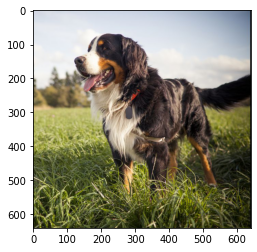

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image("images/large_dog.jpg")

plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [4]:
model = models.inception_v3(pretrained=True)

In [5]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [6]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [7]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.91473156, 239, 'Bernese_mountain_dog'),
 (0.051834784, 240, 'Appenzeller'),
 (0.020381039, 241, 'EntleBucher'),
 (0.013044636, 238, 'Greater_Swiss_Mountain_dog'),
 (1.7456049e-06, 214, 'Gordon_setter'))

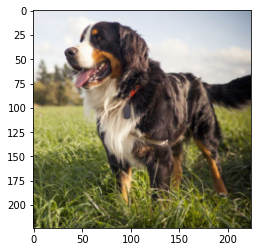

In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

plt.imshow(np.array(pill_transf(img)))

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=80)

explainer = lime_image.LimeImageExplainer()

explanation_100 = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=100,
                                         segmentation_fn= segmenter)

explanation_1000 = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000,
                                         segmentation_fn= segmenter)

explanation_4000 = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=4000,
                                         segmentation_fn= segmenter)

explanation_10000 = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=10000,
                                         segmentation_fn= segmenter) # number of images that will be sent to classification function

/home/minhvu/myroot/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.47294e-18): result may not be accurate.
  overwrite_a=True).T


In [12]:
# from skimage.segmentation import mark_boundaries

# temp, mask_lime = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
# img_boundry1 = mark_boundaries(temp/255.0, mask_lime)
# plt.imshow(img_boundry1)


In [13]:
def get_torch_mask(mask):
    mask_ = 1 - mask
    torch_mask = torch.from_numpy(mask_)
    torch_mask = torch_mask.unsqueeze(0)
    torch_mask = torch_mask.unsqueeze(0)
    torch_mask = torch_mask.repeat(1, 3, 1, 1)
    return torch_mask.float()

In [14]:
import time
from advertorch.attacks import FGM, FGSM 
from advertorch.utils import  _get_norm_batch as get_norm
from advertorch.context import ctx_noparamgrad_and_eval


def compute_c_Eval(data, mask, model, adv_type = 'FGM', step_size = 0.01, max_iter = 100):
    
    start = time.time()
    model.eval()
    output = model(data)
    pred_label = output.max(1, keepdim=True)[1][:,0]
    old_label = output.argmax().item()
    delta = torch.zeros_like(data)
    prev_data = data.clone()
    
    if adv_type == 'FGM':
        adversary = FGM(model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=step_size, clip_min=data.min().item(), 
                                          clip_max=data.max().item(), targeted=False)
    else:
        adversary = FGSM(model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=step_size, clip_min=data.min().item(), 
                                          clip_max=data.max().item(), targeted=False)
    
    for i in range(max_iter):
        with ctx_noparamgrad_and_eval(model):
            adv_data = adversary.perturb(prev_data, pred_label)
        
        delta = adv_data - prev_data
        delta = delta * mask
        adv_data = prev_data + delta
        new_label = model(adv_data).argmax().item()
        if new_label != old_label:
            break
        prev_data = adv_data.clone()
    if (new_label != old_label):
        print("Success at iteration: ", i)
    else:
        print("Fail")
    print("Duration: ", time.time() - start)
    
    return adv_data

In [15]:
adv_type_ = 'FGSM'
step_size_ = 0.0001
max_iter_ = 100

In [16]:
upper_no_seg = 50
mask_limes = []
for i in range(0,upper_no_seg):
    temp, mask_lime = explanation_100.get_image_and_mask(explanation_100.top_labels[0], positive_only=True, num_features=i, hide_rest=True)
    mask_limes.append(mask_lime)

c_limes = []
for mask_lime in mask_limes:
    torch_mask_lime = get_torch_mask(mask_lime)
    adv_lime = compute_c_Eval(img_t,torch_mask_lime, model, 
                          adv_type = adv_type_, step_size = step_size_, max_iter = max_iter_)
    diff_lime = img_t - adv_lime
    c_lime = get_norm(diff_lime, 2).item()
    c_limes.append(c_lime)
    print("c-Eval:", c_lime)

c_limes_100 = c_limes

Success at iteration:  24
Duration:  10.312027215957642
c-Eval: 0.837736964225769
Success at iteration:  24
Duration:  10.466957807540894
c-Eval: 0.8345519304275513
Success at iteration:  25
Duration:  10.726356744766235
c-Eval: 0.8624719977378845
Success at iteration:  25
Duration:  10.476758003234863
c-Eval: 0.8594897985458374
Success at iteration:  25
Duration:  10.722090005874634
c-Eval: 0.855621874332428
Success at iteration:  25
Duration:  10.0887770652771
c-Eval: 0.8511044979095459
Success at iteration:  25
Duration:  10.284337282180786
c-Eval: 0.8469729423522949
Success at iteration:  26
Duration:  10.792883157730103
c-Eval: 0.8731399774551392
Success at iteration:  27
Duration:  11.289581060409546
c-Eval: 0.9000408053398132
Success at iteration:  27
Duration:  11.98194408416748
c-Eval: 0.8949764370918274
Success at iteration:  27
Duration:  11.534211874008179
c-Eval: 0.8909762501716614
Success at iteration:  28
Duration:  11.506619215011597
c-Eval: 0.9167815446853638
Success a

In [17]:
upper_no_seg = 50
mask_limes = []
for i in range(0,upper_no_seg):
    temp, mask_lime = explanation_1000.get_image_and_mask(explanation_1000.top_labels[0], positive_only=True, num_features=i, hide_rest=True)
    mask_limes.append(mask_lime)

c_limes = []
for mask_lime in mask_limes:
    torch_mask_lime = get_torch_mask(mask_lime)
    adv_lime = compute_c_Eval(img_t,torch_mask_lime, model, 
                          adv_type = adv_type_, step_size = step_size_, max_iter = max_iter_)
    diff_lime = img_t - adv_lime
    c_lime = get_norm(diff_lime, 2).item()
    c_limes.append(c_lime)
    print("c-Eval:", c_lime)

c_limes_1000 = c_limes

Success at iteration:  24
Duration:  10.685407638549805
c-Eval: 0.837736964225769
Success at iteration:  25
Duration:  10.75298523902893
c-Eval: 0.8662887811660767
Success at iteration:  25
Duration:  10.729552030563354
c-Eval: 0.8622754216194153
Success at iteration:  26
Duration:  11.43171739578247
c-Eval: 0.8895748853683472
Success at iteration:  26
Duration:  11.368283987045288
c-Eval: 0.8854786157608032
Success at iteration:  27
Duration:  11.810009479522705
c-Eval: 0.9113104343414307
Success at iteration:  28
Duration:  11.49048638343811
c-Eval: 0.9384687542915344
Success at iteration:  28
Duration:  12.047047138214111
c-Eval: 0.9344674944877625
Success at iteration:  29
Duration:  12.802611112594604
c-Eval: 0.9607755541801453
Success at iteration:  29
Duration:  12.605687379837036
c-Eval: 0.9554587602615356
Success at iteration:  29
Duration:  12.764369249343872
c-Eval: 0.9506118297576904
Success at iteration:  30
Duration:  12.983338594436646
c-Eval: 0.974649965763092
Success a

In [18]:
upper_no_seg = 50
mask_limes = []
for i in range(0,upper_no_seg):
    temp, mask_lime = explanation_4000.get_image_and_mask(explanation_4000.top_labels[0], positive_only=True, num_features=i, hide_rest=True)
    mask_limes.append(mask_lime)

c_limes = []
for mask_lime in mask_limes:
    torch_mask_lime = get_torch_mask(mask_lime)
    adv_lime = compute_c_Eval(img_t,torch_mask_lime, model, 
                          adv_type = adv_type_, step_size = step_size_, max_iter = max_iter_)
    diff_lime = img_t - adv_lime
    c_lime = get_norm(diff_lime, 2).item()
    c_limes.append(c_lime)
    print("c-Eval:", c_lime)

c_limes_4000 = c_limes

Success at iteration:  24
Duration:  9.930502653121948
c-Eval: 0.837736964225769
Success at iteration:  25
Duration:  10.256993532180786
c-Eval: 0.8662887811660767
Success at iteration:  25
Duration:  11.244016408920288
c-Eval: 0.8622754216194153
Success at iteration:  26
Duration:  11.02804160118103
c-Eval: 0.8895748853683472
Success at iteration:  27
Duration:  11.76836109161377
c-Eval: 0.9166110157966614
Success at iteration:  27
Duration:  11.180326700210571
c-Eval: 0.9137994050979614
Success at iteration:  28
Duration:  11.82992172241211
c-Eval: 0.9393044114112854
Success at iteration:  29
Duration:  12.466194152832031
c-Eval: 0.963644802570343
Success at iteration:  29
Duration:  12.000256061553955
c-Eval: 0.9589137434959412
Success at iteration:  30
Duration:  12.452990531921387
c-Eval: 0.9829033613204956
Success at iteration:  30
Duration:  12.237029552459717
c-Eval: 0.9801422357559204
Success at iteration:  31
Duration:  12.756025552749634
c-Eval: 1.0033905506134033
Success at

In [19]:
upper_no_seg = 50
mask_limes = []
for i in range(0,upper_no_seg):
    temp, mask_lime = explanation_10000.get_image_and_mask(explanation_10000.top_labels[0], positive_only=True, num_features=i, hide_rest=True)
    mask_limes.append(mask_lime)

c_limes = []
for mask_lime in mask_limes:
    torch_mask_lime = get_torch_mask(mask_lime)
    adv_lime = compute_c_Eval(img_t,torch_mask_lime, model, 
                          adv_type = adv_type_, step_size = step_size_, max_iter = max_iter_)
    diff_lime = img_t - adv_lime
    c_lime = get_norm(diff_lime, 2).item()
    c_limes.append(c_lime)
    print("c-Eval:", c_lime)

c_limes_10000 = c_limes

Success at iteration:  24
Duration:  10.550484418869019
c-Eval: 0.837736964225769
Success at iteration:  25
Duration:  10.658439874649048
c-Eval: 0.8662887811660767
Success at iteration:  25
Duration:  10.36162543296814
c-Eval: 0.8622754216194153
Success at iteration:  26
Duration:  10.507061243057251
c-Eval: 0.8895748853683472
Success at iteration:  27
Duration:  11.494768619537354
c-Eval: 0.9166110157966614
Success at iteration:  27
Duration:  11.570485830307007
c-Eval: 0.9129261374473572
Success at iteration:  28
Duration:  12.002000093460083
c-Eval: 0.9398555755615234
Success at iteration:  29
Duration:  12.493193864822388
c-Eval: 0.9658065438270569
Success at iteration:  29
Duration:  12.314237833023071
c-Eval: 0.9607945680618286
Success at iteration:  30
Duration:  12.773627996444702
c-Eval: 0.9847006797790527
Success at iteration:  31
Duration:  12.801160335540771
c-Eval: 1.0070480108261108
Success at iteration:  31
Duration:  12.521201848983765
c-Eval: 1.0018794536590576
Succes

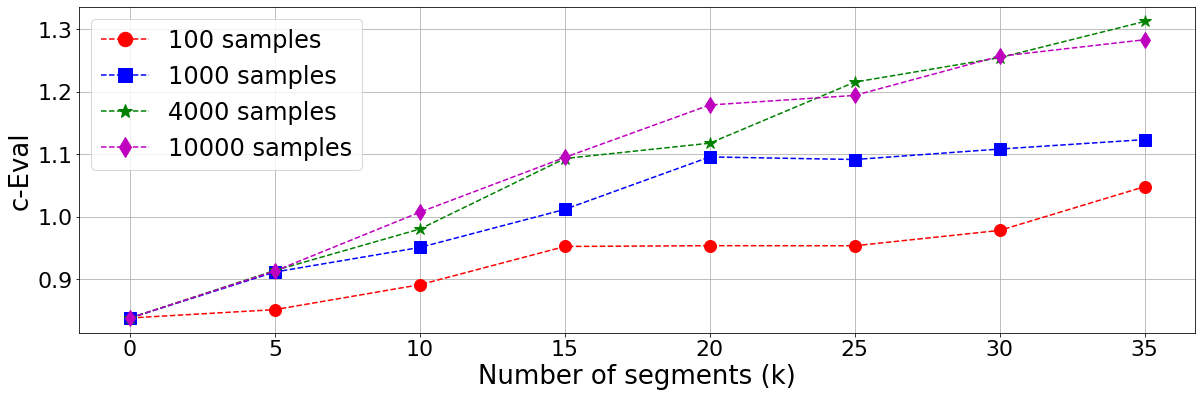

In [129]:
upper_plot = 40

t =[i for i in range(0,upper_plot) if i%5 == 0]
c_100 = [c_limes_100[i] for i in t]
c_1000 = [c_limes_1000[i] for i in t]
c_4000 = [c_limes_4000[i] for i in t]
c_10000 = [c_limes_10000[i] for i in t]


fig, ax = plt.subplots(figsize=(20,6))


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)

ax.set_xlabel('Number of segments (k)', fontsize=26)
ax.set_ylabel('c-Eval', fontsize=26)

ax.plot(t, c_100, linestyle='--', marker='o', color='r', markersize=12, label = '100 samples') 
ax.plot(t, c_1000, linestyle='--', marker='s', color='b', markersize=12, label = '1000 samples') 
ax.plot(t, c_4000, linestyle='--', marker='*', color='g', markersize=12, label = '4000 samples')
ax.plot(t, c_10000, linestyle='--', marker='d', color='m', markersize=12, label = '10000 samples') 
ax.grid()
ax.legend(loc="upper left", markerscale=1.2, scatterpoints=1, fontsize=24)

plt.savefig('results/cplot.png', bbox_inches='tight')


plt.show()

In [80]:
from skimage.segmentation import mark_boundaries

def convert_back_for_view(torch_image):
    x = torch_image.clone()
    _,c,w,h = x.shape
    y = np.zeros((w,h,c))
    for i in range(c):
        y[:,:,i] = x[0,i,:,:]
    return y/5.5 + 0.5

In [82]:

import matplotlib.patches as patches

# rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect)

# plt.show()

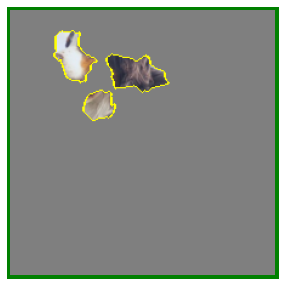

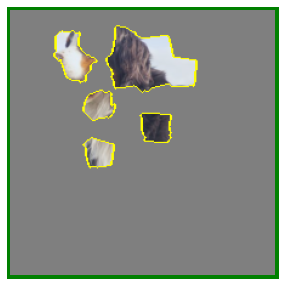

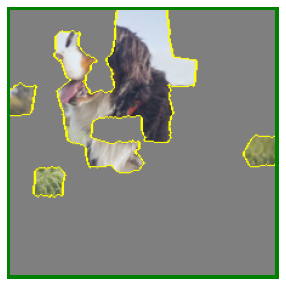

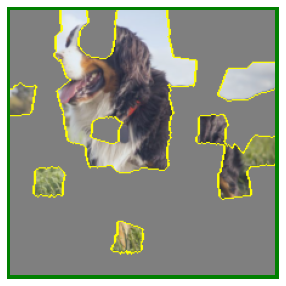

In [130]:
original = convert_back_for_view(img_t)

mask_limes = []
for i in range(0,upper_no_seg):
    temp, mask_lime = explanation_4000.get_image_and_mask(explanation_4000.top_labels[0], positive_only=True, num_features=i, hide_rest=True)
    mask_limes.append(mask_lime)

number_of_segment = [5,10,20,30]   
for no_s in number_of_segment:
    mask_lime = mask_limes[no_s]

    temp_lime = original.copy()
    temp_lime = temp_lime - 0.5
    for i in range(temp_lime.shape[2]):
        temp_lime[:,:,i] = temp_lime[:,:,i] * mask_lime
    temp_lime = temp_lime + 0.5

    fig2 = plt.figure(figsize = (5,5))
    a = fig2.add_subplot(1, 1, 1)
    plt.axis('off')
    imgplot = plt.imshow(mark_boundaries(temp_lime, mask_lime))

    rect = patches.Rectangle((0,0),222,222,linewidth=4,edgecolor='g',facecolor='none')
    a.add_patch(rect)

    # a.set_title('LIME explanation')
    plt.savefig('results/c4000_{:02d}.png'.format(no_s), bbox_inches='tight') 